# 1.从牌谱文件中还原对局

#### 1.1 读取牌谱文件中的洗牌信息，并根据\<init\>标签初始化table

In [1]:
from base_module import *
import os

year = 2015
path = f'/data/satori_hdd4/Ren/dataset/{year}'
file_name_list = os.listdir(path)




## 多线程

In [4]:
from tqdm import tqdm
from pymahjong.replayer import replay, worker, calculate
from multiprocessing import Queue, Process



input = Queue()
output = Queue()
num_worker = 64

dataset = []
for file_name in file_name_list[:100]:
    input.put((replay, (path, file_name)))

for i in range(num_worker):
    Process(target=worker, args=(input, output)).start()

dataset = []
label = []
counter = {
    'success': 0,
    'failed': 0,
    'skip': 0,
    'type_error': 0
}
for i in tqdm(range(len(file_name_list[:100]))):
    data = output.get()
    if data is None:
        counter['skip'] += 1
    else:
        if data['success']:
            dataset.extend(data['data'])
            label.extend(data['label'])

            counter['success'] += 1
        else:
            counter['failed'] += 1

for i in range(num_worker):
    input.put('STOP')
    


100%|██████████| 100/100 [00:02<00:00, 36.21it/s]


In [9]:
from base_module import label_Collator

label_collator = label_Collator()
tensor_label = label_collator(label)
print(tensor_label.shape)

torch.Size([15087])


In [7]:
label

[[30],
 [8],
 [44],
 [],
 [1, 24, 11, 37, 8, 30, 42],
 [30, 45, 8, 35, 32, 25, 15],
 [30, 18, 9, 37, 0, 45, 16, 45],
 [26, 32, 27, 45, 21, 16],
 [9, 26, 19, 34, 33, 31, 15],
 [29, 26, 35, 33, 31, 6, 45],
 [28, 45, 0, 19, 28, 45, 41, 21, 42],
 [27, 10, 21, 9, 18],
 [30, 7, 23, 45],
 [22, 30, 37, 7, 5, 37, 1, 42],
 [25, 24, 24, 15, 45, 5],
 [30, 31, 29, 45, 16, 45, 0],
 [27, 26, 8, 33, 45, 7, 10, 45, 25, 45, 41, 15],
 [29, 20, 7, 28, 31, 45, 41, 4, 43],
 [7, 8, 30, 8, 2, 45, 27, 45, 4],
 [31, 33, 30, 19, 28, 28, 45, 25],
 [28, 26, 7, 2, 37, 20, 10, 33, 12, 23],
 [29, 10, 35, 6, 23, 17, 16, 37, 31, 45, 1, 22, 43],
 [30, 26, 30, 27, 29, 45, 32, 8, 45, 0, 19],
 [0, 31, 45, 28, 27, 30, 8, 45, 10],
 [28, 8, 31, 7, 24, 26, 45, 46, 15, 42],
 [17, 14, 12, 45, 12, 29, 37, 21, 14, 21],
 [26, 45, 9, 45, 8, 45, 28, 33, 7, 45, 7],
 [29, 17, 26, 31, 45, 28, 45, 10],
 [18, 30, 37, 27, 33, 16, 2, 5],
 [29, 10, 33, 2, 0, 45, 46, 14, 45, 43],
 [17, 45, 26, 33, 0, 23, 4],
 [45, 27, 32, 0, 9, 45, 18, 45, 7]

In [ ]:
output.qsize()

In [ ]:
data = output.get()
print(type(data))

In [ ]:
isinstance(data, list)

In [ ]:
len(dataset)

In [ ]:
print(env.get_curr_player_id())
print(env.get_valid_actions())

In [ ]:
print(env.t.to_string())

In [ ]:
# import torch

# kyoku = 0
# player = 0

# training_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(training_device)

# config = GPT2Config(n_embd=512, n_layer=8, n_head=8, n_positions=128)
# model = Policy_Network(config).to(training_device)

# input_collator = myCollator(device=training_device)
# input = []
# labels = []
# for kyoku, label in zip(data['obs'], data['label']):
#     input.extend(kyoku)
#     labels.extend(label)
# input = input_collator(input)
# output = model(**input)


# label_collator = label_Collator(device=training_device)
# label = label_collator(labels)

# criteria = torch.nn.CrossEntropyLoss()
# loss = criteria(output['action_logits'], label)
# print(input['action_list'].shape)
# print(label.shape)
# print(loss)

# 2. 验证模型效果

In [52]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torch

# 使用第一个可用的 GPU，即设备 1
inference_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# training_device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print("inference_device:", inference_device)
# print("training_device:", training_device)

import numpy as np
from base_module import *

from pymahjong import *
from pymahjong import MahjongPyWrapper as pm
from pymahjong.myEnv_pymahjong import myMahjongEnv

env = myMahjongEnv()
obs, info = env.reset()

config = GPT2Config(n_embd=512, n_layer=8, n_head=8, n_positions=128)
inference_model = Policy_Network(config).to(inference_device)
inference_collator = inference_Collator(device=inference_device)

inference_model.load_state_dict(torch.load("./checkpoints/model_2015_3.pth"))
inference_model.eval()

action_represenation = {
    0: 'dicard 1m',
    1: 'dicard 2m',
    2: 'dicard 3m',
    3: 'dicard 4m',
    4: 'dicard 5m',
    5: 'dicard 6m',
    6: 'dicard 7m',
    7: 'dicard 8m',
    8: 'dicard 9m',
    9: 'dicard 1p',
    10: 'dicard 2p',
    11: 'dicard 3p',
    12: 'dicard 4p',
    13: 'dicard 5p',
    14: 'dicard 6p',
    15: 'dicard 7p',
    16: 'dicard 8p',
    17: 'dicard 9p',
    18: 'dicard 1s',
    19: 'dicard 2s',
    20: 'dicard 3s',
    21: 'dicard 4s',
    22: 'dicard 5s',
    23: 'dicard 6s',
    24: 'dicard 7s',
    25: 'dicard 8s',
    26: 'dicard 9s',
    27: 'dicard east',
    28: 'dicard south',
    29: 'dicard west',
    30: 'dicard north',
    31: 'dicard white',
    32: 'dicard green',
    33: 'dicard red',
    34: 'chi_left',
    35: 'chi_middle',
    36: 'chi_right',
    37: 'pon',
    38: 'ankan',
    39: 'minkan',
    40: 'kakan',
    41: 'riichi',
    42: 'ron',
    43: 'tsumo',
    44: 'kyushukyuhai',
    45: 'pass_naki',
    46: 'pass_riichi'
}
obs, info = env.reset()

inference_device: cuda:0


Pt: 25000
Wind: East
Hand: 4m 6m 2p 3p 6p 2s 7s 9s 
Calls: (6z)6z6z (4s)4s4s 
River: 3z1h 2m5h 8s9h 3z13h 7z17h 7p21h 7p25h 5m29h 
Riichi: No
Menzen: No
model selected action: dicard 3p
action_probs: [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.2490493e-11 0.0000000e+00
 2.2952432e-10 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 2.8721346e-03 9.9712306e-01 0.0000000e+00 0.0000000e+00 6.7706257e-10
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.6138720e-13
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.7724384e-06
 0.0000000e+00 1.3086180e-11 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00]


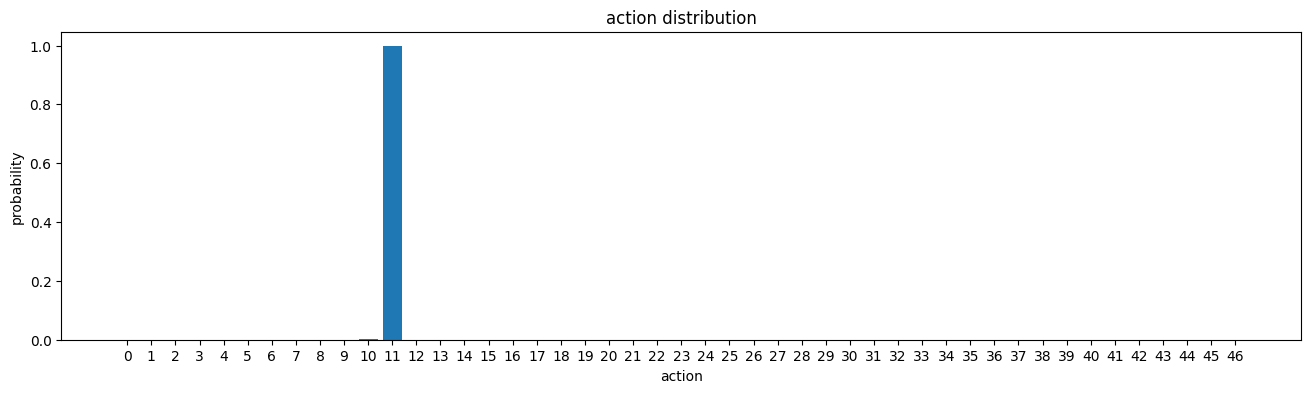

In [95]:
import matplotlib.pyplot as plt

curr_pid = env.get_curr_player_id()


input = inference_collator(obs)
with torch.no_grad():
    output = inference_model.inference(**input)
probs = output["action_probs"].cpu().numpy()
action = np.random.choice(47, p=probs[0])


curr_pid = env.get_curr_player_id()
print(env.t.players[curr_pid].to_string())
print("model selected action:", action_represenation[action])
print("action_probs:", probs[0])

obs, r, done, _, info = env.step(action)
# 绘制动作概率分布
plt.figure(figsize=(16, 4))
plt.bar(range(47), probs[0])
plt.xticks(np.arange(0, 47, 1))

plt.xlabel("action")
plt.ylabel("probability")
plt.title("action distribution")
plt.show()



In [88]:
print(env.t.to_string())

Yama: 1m 2z 8s 8p 8m 7p 5p 3s 1p 1m 9s 1m 4p 4p (Wanpai)| 6s 6z 3m 7z 7s 5z 8m 2s 0s 1z 2p 2s 6s 1s 4m 1z 5m 1z 4z 8p 3m 9p 2m 3p 6p 5s 4p 3s 9m 5s 6m 7m 1s 7p 6m 8s 5z 7z 2p 7s 4s 4z 4m 
Dora Indicator(s):7p 
Remaining tiles: 43
Player 0: 
Pt: 25000
Wind: North
Hand: 1m 5m 7m 8p 9p 1s 2s 5s 7s 3z 3z 4z 7z 
River: 6s4h 6p8h 4p12h 2m16h 9s20h 1p24h 6z28h- 
Riichi: No
Menzen: Yes
Player 1: 
Pt: 25000
Wind: East
Hand: 4m 5m 6m 2p 3p 6p 2s 4s 4s 7s 9s 
Calls: (6z)6z6z 
River: 3z1h 2m5h 8s9h 3z13h 7z17h 7p21h 7p25h 
Riichi: No
Menzen: No
Player 2: 
Pt: 25000
Wind: South
Hand: 2m 3m 0m 9m 1p 1p 2p 3p 5p 6p 3s 2z 5z 
River: 2z2h 8s6h 5z10h 3s14h 7m18h- 8m22h 2z26h 
Riichi: No
Menzen: Yes
Player 3: 
Pt: 25000
Wind: West
Hand: 3m 4m 9m 9m 3p 0p 5p 8p 1s 4s 
Calls: 6m(7m)8m 
River: 9s3h 7m7h 9p11 6s15h 9p19h 1z23h 4z27h 
Riichi: No
Menzen: No

Oya player 1
Honba: 0
Kyoutaku: 0

